In [1]:
!pip install --upgrade torchtext
!pip install tqdm

     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 1.0MB 17.5MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


In [0]:
import torch
import torchtext

# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# nltk
import nltk

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter, defaultdict
import tqdm
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [0]:
# DATASET
DATASET_COLUMNS = ["class", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 200
VALIDATION_SPLIT = 0.2

# EXPORT
PYTORCH_MODEL = "model.h5"

In [0]:
def clean_str(string):
    # by https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [0]:
from nltk import word_tokenize, sent_tokenize
from tqdm import tqdm

def prep_text(path, train_ratio, eval_ratio, encoding, columns, min_word_count=5, save_path=None):
    # load
    raw_text = pd.read_csv(path, encoding=encoding, names=columns)
    raw_text = raw_text.sample(100000, random_state=42)

    # label
    labels = list(raw_text['class'])

    # sentence tokenize
    texts = []
    for text_ in list(raw_text['text']):
        texts.append(sent_tokenize(text_))

    # word count, build hierarchical documents
    texts_hierarchy = []
    word_count = defaultdict(int)
    print('text cleaning...')
    for sents in tqdm(texts):
        clean_sent = []
        for s in sents:
            cleaning = clean_str(s)
            clean_sent.append(cleaning)
            words = word_tokenize(cleaning)
            for w in words:
                word_count[w] += 1
        texts_hierarchy.append(clean_sent)

    # build vocabulary, remove unique words
    word_vocab = {'UNK':0}
    i = 1
    for w, f in word_count.items():
        if f > min_word_count:
            word_vocab[w] = i
            i += 1
    
    # text encoding
    print('text encoding...')
    encode_text = []
    for sent in tqdm(texts_hierarchy):
        encode_doc = []
        for s in sent:
            encode_ = [word_vocab.get(word, 0) for word in word_tokenize(s)]
            encode_doc.append(encode_)
        encode_text.append(encode_doc)

    # train/eval/test split
    train_ind = int(len(labels) * train_ratio)
    eval_ind = int(len(labels) * eval_ratio)
    train_x, train_y = encode_text[:train_ind], labels[:train_ind]
    eval_x, eval_y = encode_text[train_ind:train_ind+eval_ind], labels[train_ind:train_ind+eval_ind]
    test_x, test_y = encode_text[train_ind+eval_ind:], labels[train_ind+eval_ind:]

    train_data = {'x':train_x, 'y':train_y}
    eval_data = {'x':eval_x, 'y':eval_y}
    test_data = {'x':test_x, 'y':test_y}

    # save
    if save_path:
        path_ = save_path
    else:
        path_ = os.path.split(path)[0]

    save_lst = [train_data, eval_data, test_data, word_vocab]
    save_name = ['train_data_small.pkl', 'eval_data_small.pkl', 'test_data_small.pkl', 'word_vocab_small.pkl']

    for file_, name_ in zip(save_lst, save_name):
        with open(os.path.join(path_, '{}'.format(name_)), 'wb') as f:
            pickle.dump(file_, f)

In [7]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
%%time
prep_text("/content/drive/My Drive/Colab Notebooks/yelp2015/yelp_full.csv", 0.7, 0.1, DATASET_ENCODING, DATASET_COLUMNS, save_path="/content/drive/My Drive/Colab Notebooks/yelp2015/")

  0%|          | 70/100000 [00:00<02:24, 689.33it/s]

text cleaning...


  0%|          | 83/100000 [00:00<02:00, 828.47it/s]

text encoding...


100%|██████████| 100000/100000 [02:11<00:00, 762.15it/s]


CPU times: user 5min 21s, sys: 2.93 s, total: 5min 23s
Wall time: 5min 24s


In [0]:
from torch.utils.data import Dataset, DataLoader

class text_dataloader(Dataset):
    def __init__(self, data_path, max_sent, max_doc, mode):
        self.data_path = data_path
        self.max_sent = max_sent
        self.max_doc = max_doc

        self.mode = mode

        # load
        with open(os.path.join(data_path, 'word_vocab_small.pkl'), 'rb') as f:
            self.word_vocab = pickle.load(f)
        with open(os.path.join(data_path, '{}_data_small.pkl'.format(mode)), 'rb') as f:
            data_ = pickle.load(f)
           
        self.x, self.y = data_['x'], data_['y']
        
        self.vocab_size = len(self.word_vocab)
        self.n_classes = len(np.unique(self.y))
        
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.x[idx]
        label = self.y[idx] - 1

        batch_x = np.zeros([self.max_doc, self.max_sent])
        sent_length = []
        
        if len(text) > self.max_doc:
            text = text[-self.max_doc:]

        for si, sent in enumerate(text):
            if len(sent) > self.max_sent:
                sent = sent[-self.max_sent:]
            batch_x[si][:len(sent)] = sent
            sent_length.append(len(sent))
        
        sent_length = sent_length + [0]*(self.max_doc - len(sent_length))
        doc_length = [len(text)]

        return batch_x, np.array([label]), np.array(sent_length), np.array(doc_length)

In [0]:
def get_dataloader(data_path, max_sent, max_doc, mode, batch_size, num_workers):
    dataloader = text_dataloader(data_path, max_sent, max_doc, mode)
    data_loader = DataLoader(dataset=dataloader, 
                             batch_size=batch_size, 
                             shuffle=(True if mode=='train' else False), 
                             num_workers=num_workers,
                             drop_last=True)
    return data_loader

In [0]:
import torch.nn as nn
import torch.nn.init as init
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size=100, bi=True):
        super(AttentionLayer, self).__init__()
        self.hidden_size = (hidden_size*2 if bi else hidden_size)
        self.linear_ = nn.Linear(self.hidden_size, self.hidden_size)
        self.tanh_ = nn.Tanh()
        self.softmax_ = nn.Softmax(dim=1)

    def forward(self, x):
        u_context = torch.nn.Parameter(torch.FloatTensor(self.hidden_size).normal_(0, 0.01)).cuda()
        h = self.tanh_(self.linear_(x)).cuda()
        alpha = self.softmax_(torch.mul(h, u_context).sum(dim=2, keepdim=True))  # (x_dim0, x_dim1, 1)
        attention_output = torch.mul(x, alpha).sum(dim=1)  # (x_dim0, x_dim2)
        return attention_output, alpha


class HierarchicalAttentionNet(nn.Module):
    def __init__(self, vocab_size, hidden_size, n_classes, pre_embed=None, embed_fine_tune=True):
        super(HierarchicalAttentionNet, self).__init__()
        self.embed_size = hidden_size * 2
        self.hidden_size = hidden_size
        self.n_classes = n_classes

        # word level
        self.embed = nn.Embedding(vocab_size, self.embed_size)
        if pre_embed:
            self.weight = nn.Parameter(pre_embed, requires_grad=(True if embed_fine_tune else False))
        else:
            init.normal_(self.embed.weight, std=0.01)
        self.word_rnn = nn.GRU(self.embed_size, hidden_size, bidirectional=True)
        self.word_att = AttentionLayer(hidden_size)

        # sent level
        self.sent_rnn = nn.GRU(self.embed_size, hidden_size, bidirectional=True)
        self.sent_att = AttentionLayer(hidden_size)

        # fully connected
        self.linear = nn.Linear(self.embed_size, self.n_classes)

    def forward(self, x, sent_lengths, sent_idx, doc_lengths):
        # x shape -> (batch, max_doc, max_sent)
        # 'sent_lengths', 'doc_lengths' must sorted in decreasing order
        # sent_lengths -> (batch*max_doc, )
        # doc_lengths -> (batch, )

        max_sent_len = x.shape[2]
        max_doc_len = x.shape[1]

        # word embedding
        word_embed = self.embed(x) # (batch, max_doc, max_sent, embed_size)

        # split sent_length=0 part (length must > 0 in 'pack_padded_sequence')
        word_embed = word_embed.view(-1, max_sent_len, self.embed_size) # (batch*max_doc, max_sent, embed_size)
        word_embed = word_embed[sent_lengths] # sort length
        non_zero_idx = len(torch.nonzero(sent_lengths))
        word_embed_sltd = word_embed[:non_zero_idx]
        word_embed_remain = word_embed[non_zero_idx:]
        sent_lengths_sltd = sent_lengths[:non_zero_idx]

        # word encoding
        word_packed_input = pack_padded_sequence(word_embed_sltd, sent_lengths_sltd.cpu().numpy(), batch_first=True)
        word_packed_output, _ = self.word_rnn(word_packed_input)
        word_encode, _ = pad_packed_sequence(word_packed_output, batch_first=True) # (non_zero_idx, max_sent_len, hidden_size*2)

        # merge sent_length=0 part
        if word_encode.shape[1] != word_embed.shape[1]:
            word_encode_dim = word_encode.shape[1]
            word_embed_remain = word_embed_remain[:, :word_encode_dim, :]
            max_sent_len = word_encode_dim
        word_encode = torch.cat((word_encode, word_embed_remain), 0) # (batch*max_doc, max_sent, hidden_size*2)

        # unsort
        sort_idx = torch.LongTensor([[[i]*self.embed_size]*max_sent_len for i in sent_idx.cpu().detach().numpy()])
        unsort_word_encode = word_encode.new(*word_encode.size())
        unsort_word_encode = unsort_word_encode.scatter_(0, sort_idx.cuda(), word_encode)

        # word attention
        sent_vector, sent_alpha = self.word_att(unsort_word_encode) # (batch*max_doc, hidden_size*2)

        # sent encoding
        sent_vector = sent_vector.view(-1, max_doc_len, self.hidden_size*2) # (batch, max_doc_len, hidden_size*2)
        sent_packed_input = pack_padded_sequence(sent_vector, doc_lengths.cpu().numpy(), batch_first=True)
        sent_packed_output, _ = self.sent_rnn(sent_packed_input)
        sent_encode, _ = pad_packed_sequence(sent_packed_output, batch_first=True) # (batch, max_doc_len, hidden_size*2)

        # sent attention
        doc_vector, doc_alpha = self.sent_att(sent_encode) # (batch, hidden_size*2)

        # fc, softmax
        out = self.linear(doc_vector)

        return out

In [0]:

class Arguments(object):
  def __init__(self):
    self.data_path = "/content/drive/My Drive/Colab Notebooks/yelp2015/"
    self.save_path = "/content/drive/My Drive/Colab Notebooks/yelp2015/"
    self.max_sent = 40
    self.max_doc = 40
    self.mode = 'train'
    self.batch_size = 64
    self.hidden_size = 50
    self.num_epochs = 10
    self.num_workers = 6
    self.print_iters = 10
    self.eval_iters = 500
    self.decay_iters = 5000
    self.save_iters = 1000
    self.test_iters = 1000
    self.clip = 0.5
    self.lr = 0.01
    self.momentum = 0.9
    self.beta1 = 0.5
    self.beta2 = 0.999
    self.device = 'cuda'

args = Arguments()

In [0]:
import torch.nn as nn
import torch.optim as optim
from collections import OrderedDict
from torch.nn.utils import clip_grad_norm_

class Solver(object):
    def __init__(self, args, train_loader=None, eval_loader=None, test_loader=None):
        self.train_loader = train_loader
        self.eval_loader = eval_loader
        self.test_loader = test_loader

        if args.device:
            self.device = torch.device(args.device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.save_path = args.save_path

        self.max_sent = args.max_sent
        self.max_doc = args.max_doc

        self.num_epochs = args.num_epochs
        self.print_iters = args.print_iters
        self.eval_iters = args.eval_iters
        self.decay_iters = args.decay_iters
        self.save_iters = args.save_iters
        self.test_iters = args.test_iters
        self.lr = args.lr
        self.momentum = args.momentum
        self.beta1 = args.beta1
        self.beta2 = args.beta2
        self.clip = args.clip

        self.batch_size = args.batch_size
        self.vocab_size = (train_loader.dataset.vocab_size if train_loader else test_loader.dataset.vocab_size)
        self.n_classes = train_loader.dataset.n_classes if train_loader else test_loader.dataset.n_classes
        self.hidden_size = args.hidden_size
        self.HAN = HierarchicalAttentionNet(vocab_size=self.vocab_size, hidden_size=self.hidden_size, n_classes=self.n_classes)
        self.HAN.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.SGD(self.HAN.parameters(), lr=self.lr, momentum=self.momentum)

    def save_model(self, iter_):
        f = os.path.join(self.save_path, "HAN_{}iter.ckpt".format(iter_))
        torch.save(self.HAN.state_dict(), f)

    def load_model(self, iter_, multigpu_=None):
        f = os.path.join(self.save_path, "HAN_{}iter.ckpt".format(iter_))
        if multigpu_:
            state_d = OrderedDict()
            for k,v in torch.load(f):
                n = k[7:]
                state_d[n] = v
            self.HAN.load_state_dict(state_d)
        else:
            self.HAN.load_state_dict(torch.load(f))

    def sort_tensor(self, x, y, sent_len, doc_len):
        # sort sent_lengths
        sent_len, sent_idx = sent_len.sort(1, descending=True)
        sorted_sent_x = torch.zeros(x.numpy().shape)
        for batch_i in range(self.batch_size):
            sorted_sent_x[batch_i] = x[batch_i][sent_idx[batch_i]]
        sent_len = sent_len.view(-1).to(self.device)
        sent_len, sent_idx = sent_len.sort(0, descending=True)

        # sort doc_lengths
        doc_len = doc_len.view(-1).to(self.device)
        if len(doc_len) > 1:
            doc_len, doc_idx = doc_len.sort(0, descending=True)
            x, y = sorted_sent_x[doc_idx].to(self.device), y[doc_idx].to(self.device)
        else: # len(doc_len) == 1
            x, y = sorted_sent_x.to(self.device), y.to(self.device)
        return x.long(), y.long(), sent_len.long(), sent_idx.long(), doc_len.long()

    def lr_decay(self):
        lr = self.lr * 0.5
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

    def train(self):
        train_losses, eval_losses = [], []
        total_iters = 0
        epoch_acc = []
        for epoch in range(1, self.num_epochs+1):
            self.HAN.train(True)

            for iter_, (x, y, sent_lengths, doc_lengths) in enumerate(self.train_loader):
                total_iters += 1
                x, y, sent_lengths, sent_idx, doc_lengths = self.sort_tensor(x, y, sent_lengths, doc_lengths)
                out = self.HAN(x, sent_lengths, sent_idx, doc_lengths)
                _, preds = torch.max(out.data, 1)
                correct = (preds == y.view(-1)).float()
                loss = self.criterion(out, y.view(-1))
                acc = correct.sum() / len(correct)
                self.HAN.zero_grad()
                self.optimizer.zero_grad()
                
                # gradeint clipping
                #clip_grad_norm_(self.HAN.parameters(), self.clip)

                loss.backward()
                self.optimizer.step()
                train_losses.append(loss.item())
                epoch_acc.append(acc.item())

                if total_iters % self.print_iters == 0:
                    print("EPOCH [{}/{}], ITER [{}/{} ({})] \nLOSS:{:.4f}\nACC:{:.4f}".format(epoch, self.num_epochs, iter_+1, len(self.train_loader), total_iters, loss.item(), acc.item()))

                # evaluation
                if total_iters % self.eval_iters == 0:
                    self.HAN.train(False)
                    self.HAN.eval()
                    eval_loss = 0.0
                    for e_x, e_y, e_sent_len, e_doc_len in self.eval_loader:
                        e_x, e_y, e_sent_len, e_sent_idx, e_doc_len = self.sort_tensor(e_x, e_y, e_sent_len, e_doc_len)
                        e_out = self.HAN(e_x, e_sent_len, e_sent_idx, e_doc_len)
                        eval_loss += self.criterion(e_out, e_y.view(-1)).item()
                    eval_loss = eval_loss/len(self.eval_loader)
                    print("==== EVALUATION ITER[{}] \n==== LOSS:{:.4f}".format(total_iters,eval_loss))
                    eval_losses.append(eval_loss)
                    self.HAN.train(True)

                # lr decay
                #if total_iters % self.decay_iters == 0:
                #    self.lr_decay()

                # save
                if total_iters % self.save_iters == 0:
                    self.save_model(total_iters)
                    np.save(os.path.join(self.save_path, 'train_loss_{}_iter.npy'.format(total_iters)), np.array(train_losses))
                    np.save(os.path.join(self.save_path, 'eval_loss_{}_iter.npy'.format(total_iters)), np.array(eval_losses))
                    np.save(os.path.join(self.save_path, 'epoch_acc_{}_iter.npy'.format(total_iters)), np.array(epoch_acc))

    def test(self):
        del self.HAN
        self.HAN = HierarchicalAttentionNet(vocab_size=self.vocab_size, hidden_size=self.hidden_size, n_classes=self.n_classes)
        self.HAN.to(self.device)
        self.load_model(self.test_iters)

        # accuracy
        correct, total = 0, 0
        with torch.no_grad():
            for x, y, sent_len, doc_len in self.test_loader:
                x, y, sent_len, sent_idx, doc_len = self.sort_tensor(x, y, sent_len, doc_len)

                out = self.HAN(x, sent_len, sent_idx, doc_len)
                _, pred = torch.max(out.data, 1)

                total += y.size(0)
                correct += (pred == y.view(-1)).sum().item()
        print('Accuracy of the network on the test data: {}%'.format(100 * correct / total))

        # figure
        import matplotlib.pyplot as plt
        import seaborn as sns
        div = 10
        train_loss = np.load(os.path.join(self.save_path, 'train_loss_{}_iter.npy'.format(self.test_iters)))
        eval_loss = np.load(os.path.join(self.save_path, 'eval_loss_{}_iter.npy'.format(self.test_iters)))
        epoch_acc = np.load(os.path.join(self.save_path, 'epoch_acc_{}_iter.npy'.format(self.test_iters)))

        fig, ax = plt.subplots(3,1,figsize=(14,10))
        sns.lineplot(range(len(train_loss)//div), [train_loss[i] for i in range(len(train_loss)) if i % div == 0], ax=ax[0])
        ax[0].set_title('Train loss', fontsize=20)
        #ax[1] = ax[0].twiny()
        sns.lineplot(range(len(eval_loss)), list(eval_loss), ax=ax[1], color='red')
        ax[1].set_title('Evaluation loss', fontsize=20)
        sns.lineplot(range(len(epoch_acc)), list(epoch_acc), ax=ax[2], color='green')
        ax[2].set_title('Accuracy', fontsize=20)


        plt.savefig(os.path.join(self.save_path, 'loss_fig.png'))

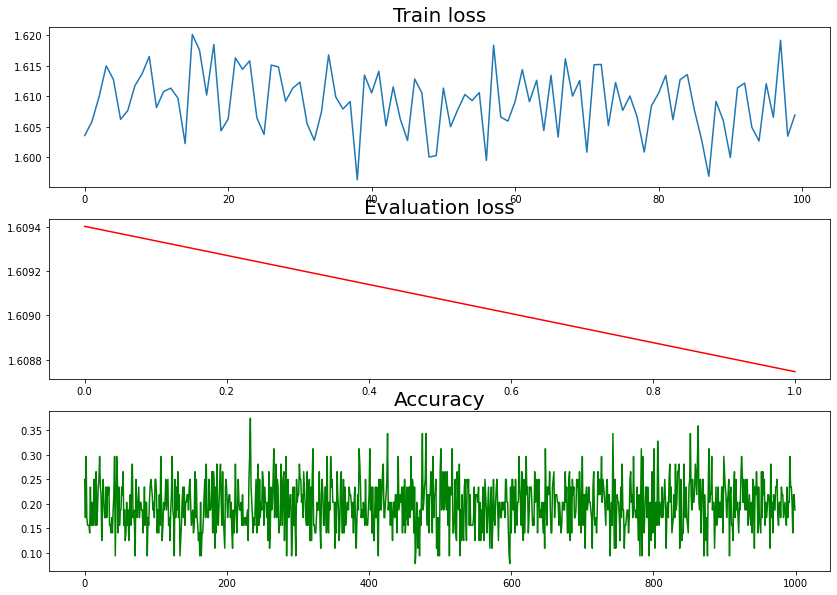

In [8]:
# figure
import matplotlib.pyplot as plt
import seaborn as sns
div = 10
train_loss = np.load(os.path.join(args.save_path, 'train_loss_{}_iter.npy'.format(args.test_iters)))
eval_loss = np.load(os.path.join(args.save_path, 'eval_loss_{}_iter.npy'.format(args.test_iters)))
epoch_acc = np.load(os.path.join(args.save_path, 'epoch_acc_{}_iter.npy'.format(args.test_iters)))

fig, ax = plt.subplots(3,1,figsize=(14,10))
sns.lineplot(range(len(train_loss)//div), [train_loss[i] for i in range(len(train_loss)) if i % div == 0], ax=ax[0])
ax[0].set_title('Train loss', fontsize=20)
#ax[1] = ax[0].twiny()
sns.lineplot(range(len(eval_loss)), list(eval_loss), ax=ax[1], color='red')
ax[1].set_title('Evaluation loss', fontsize=20)
sns.lineplot(range(len(epoch_acc)), list(epoch_acc), ax=ax[2], color='green')
ax[2].set_title('Accuracy', fontsize=20)


plt.savefig(os.path.join(args.save_path, 'loss_fig.png'))

In [20]:
train_loader = get_dataloader(data_path=args.data_path,
                                      max_sent=args.max_sent,
                                      max_doc=args.max_doc,
                                      mode=args.mode,
                                      batch_size=args.batch_size,
                                      num_workers=args.num_workers)

eval_loader = get_dataloader(data_path=args.data_path,
                              max_sent=args.max_sent,
                              max_doc=args.max_doc,
                              mode='eval',
                              batch_size=args.batch_size,
                              num_workers=args.num_workers)

solver = Solver(args, train_loader=train_loader, eval_loader=eval_loader)
solver.train()

EPOCH [1/10], ITER [10/1093 (10)] 
LOSS:1.6115
ACC:0.1875
EPOCH [1/10], ITER [20/1093 (20)] 
LOSS:1.6078
ACC:0.2969
EPOCH [1/10], ITER [30/1093 (30)] 
LOSS:1.6087
ACC:0.2344
EPOCH [1/10], ITER [40/1093 (40)] 
LOSS:1.6077
ACC:0.2812
EPOCH [1/10], ITER [50/1093 (50)] 
LOSS:1.6048
ACC:0.2500
EPOCH [1/10], ITER [60/1093 (60)] 
LOSS:1.6144
ACC:0.1875
EPOCH [1/10], ITER [70/1093 (70)] 
LOSS:1.6131
ACC:0.1562
EPOCH [1/10], ITER [80/1093 (80)] 
LOSS:1.6067
ACC:0.2188
EPOCH [1/10], ITER [90/1093 (90)] 
LOSS:1.6108
ACC:0.1406
EPOCH [1/10], ITER [100/1093 (100)] 
LOSS:1.6168
ACC:0.1406
EPOCH [1/10], ITER [110/1093 (110)] 
LOSS:1.6066
ACC:0.2188
EPOCH [1/10], ITER [120/1093 (120)] 
LOSS:1.6084
ACC:0.2344
EPOCH [1/10], ITER [130/1093 (130)] 
LOSS:1.6086
ACC:0.1875
EPOCH [1/10], ITER [140/1093 (140)] 
LOSS:1.6119
ACC:0.1875
EPOCH [1/10], ITER [150/1093 (150)] 
LOSS:1.6108
ACC:0.1562
EPOCH [1/10], ITER [160/1093 (160)] 
LOSS:1.6060
ACC:0.2188
EPOCH [1/10], ITER [170/1093 (170)] 
LOSS:1.6029
ACC:0.265

In [0]:
args.mode='test'

Accuracy of the network on the test data: 22.576121794871796%


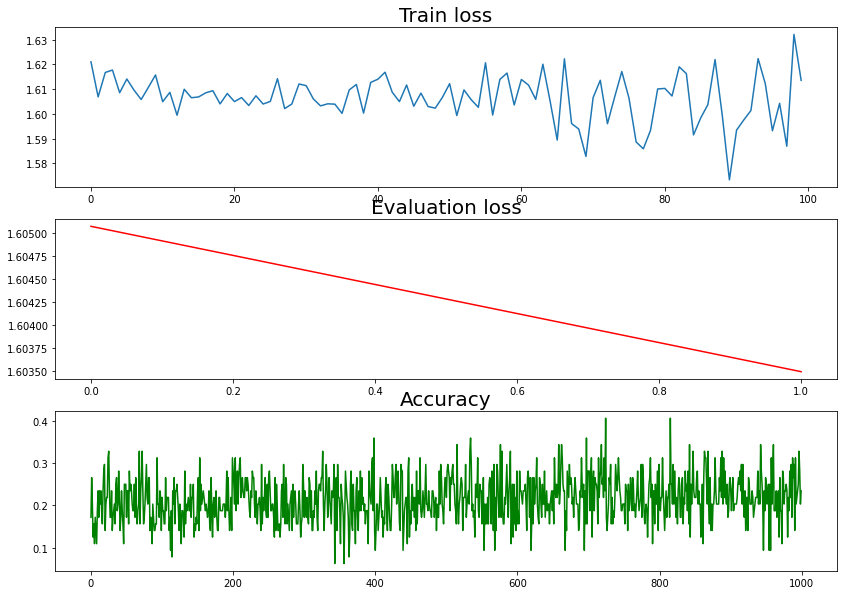

In [24]:
test_loader = get_dataloader(data_path=args.data_path,
                                     max_sent=args.max_sent,
                                     max_doc=args.max_doc,
                                     mode=args.mode,
                                     batch_size=args.batch_size,
                                     num_workers=args.num_workers)

solver = Solver(args, test_loader=test_loader)
solver.test()